In [1]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from IPython.display import display

# Data ingestion

In [166]:
url = 'https://s3.amazonaws.com/nyc-tlc/trip+data/'
files = ['green_tripdata_2021-01.parquet', 'green_tripdata_2021-02.parquet']
data_sources = [url + file for file in files]
data_destinations = ['./data/' + file for file in files]

In [167]:
for i in range(len(data_sources)):
    source = data_sources[i]
    destination = data_destinations[i]
    print(f'Downloading {data_sources[i]}')
    !curl $source -o $destination --create-dirs 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0 1302k    0  8630    0     0  14193      0  0:01:33 --:--:--  0:01:33 14217
100 1302k  100 1302k    0     0   882k      0  0:00:01  0:00:01 --:--:--  883k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
 43 1118k   43  483k    0     0   458k      0  0:00:02  0:00:01  0:00:01  458k
100 1118k  100 1118k    0     0   793k      0  0:00:01  0:00:01 --:--:--  793k


# Data preparation
- Look at the data
- Make column names and values look uniform
- Check if all the columns read correctly
- Check and transform types - categorical/numerical features

In [168]:
def read_dataframe (data_file, categorical_features=None, numerical_features=None, target=None, verbose=False):
    
    if (verbose): print(f'Pre-processing dataset {data_file}')
    df = pd.read_parquet(data_file)
    if (verbose): print(f'shape: {df.shape}')
    df.columns.str.lower().str.replace(' ','_')
    if (verbose): print(f'types:\n{df.dtypes}')
    
    categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)
    numerical_columns = list(df.dtypes[df.dtypes != 'object'].index)
    
    for column in categorical_columns:
        # This will not touch the None values, only the not None types are processed (type(df['store_and_fwd_flag'].iloc[-1]) => 'NoneType')
        df[column] = df[column].str.lower().str.replace(' ', '_')
    
    df['duration'] = (df['lpep_dropoff_datetime'] - df['lpep_pickup_datetime']).dt.seconds / 60
    
    if verbose:
        display(df.head().T)
        print(f'types:\n{df.dtypes}')
        print('\nUniques values\n')
        
        for c in df.columns:
            display(c, df[c].unique())
            
        print('\ncategorical_columns\n')
        for column in categorical_columns:
            display(f'Feature: {column}')
            display(f'Number of unique values: {df[column].nunique()}')
            display(f'Number of nulls: {df[column].isnull().sum()}')
            display(df[column].value_counts(normalize=True))
            
        print('\nnumerical_columns\n')
        for column in numerical_columns:
            display(f'Feature: {column}')
            nuniques = df[column].nunique()
            display(f'Number of unique values: {nuniques}')
            display(f'Number of nulls: {df[column].isnull().sum()}')
            if nuniques < 20:
                display(df[column].value_counts(normalize=False))
        
        sns.displot(df.duration, kind='kde')
        df['duration'].describe(percentiles=[0.1, 0.2, 0.95, 0.98, 0.99])  
        print(f'% of trips within 1-60 min: {((df.duration >= 1) & (df.duration<=60)).mean()}')
    
    df = df[(df.duration >= 1) & (df.duration<=60)]

    if not categorical_features:
        categorical_features = ['PULocationID', 'DOLocationID']
    if not numerical_features:
        numerical_features =  ['trip_distance']
    if not target:
        target = ['duration']
    df[categorical_features] = df[categorical_features].astype('str')
    df.drop(df.columns.difference(categorical_features+numerical_features+target), axis=1, inplace=True)    
    
    if verbose:
        print(f'\nfinal shape: {df.shape}')
        print(f'\nfinal types:\n{df.dtypes}')
        print(f'\ncategorical_features: {categorical_features}')
        print(f'\nnumerical_features: {numerical_features}')
        print(f'\ntarget: {target}')       
    
    return df[categorical_features+numerical_features],df[target] 
    

In [90]:
df = pd.read_parquet(data_sources[0])
df.shape

(76518, 20)

In [51]:
df.columns.str.lower().str.replace(' ','_')

Index(['vendorid', 'lpep_pickup_datetime', 'lpep_dropoff_datetime',
       'store_and_fwd_flag', 'ratecodeid', 'pulocationid', 'dolocationid',
       'passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'ehail_fee', 'improvement_surcharge',
       'total_amount', 'payment_type', 'trip_type', 'congestion_surcharge'],
      dtype='object')

In [52]:
df.dtypes

VendorID                          int64
lpep_pickup_datetime     datetime64[ns]
lpep_dropoff_datetime    datetime64[ns]
store_and_fwd_flag               object
RatecodeID                      float64
PULocationID                      int64
DOLocationID                      int64
passenger_count                 float64
trip_distance                   float64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
ehail_fee                        object
improvement_surcharge           float64
total_amount                    float64
payment_type                    float64
trip_type                       float64
congestion_surcharge            float64
dtype: object

In [53]:
categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)
numerical_columns = list(df.dtypes[df.dtypes != 'object'].index)

In [54]:
for column in categorical_columns:
    # This will not touch the None values, only the not None types are processed (type(df['store_and_fwd_flag'].iloc[-1]) => 'NoneType')
    df[column] = df[column].str.lower().str.replace(' ', '_')

In [55]:
df.head().T

,0,1,2,3,4
VendorID,2,2,2,2,2
lpep_pickup_datetime,2021-01-01 00:15:56,2021-01-01 00:25:59,2021-01-01 00:45:57,2020-12-31 23:57:51,2021-01-01 00:16:36
lpep_dropoff_datetime,2021-01-01 00:19:52,2021-01-01 00:34:44,2021-01-01 00:51:55,2021-01-01 00:04:56,2021-01-01 00:16:40
store_and_fwd_flag,n,n,n,n,n
RatecodeID,1.0,1.0,1.0,1.0,2.0
PULocationID,43,166,41,168,265
DOLocationID,151,239,42,75,265
passenger_count,1.0,1.0,1.0,1.0,3.0
trip_distance,1.01,2.53,1.12,1.99,0.0
fare_amount,5.5,10.0,6.0,8.0,-52.0


In [56]:
df.dtypes

VendorID                          int64
lpep_pickup_datetime     datetime64[ns]
lpep_dropoff_datetime    datetime64[ns]
store_and_fwd_flag               object
RatecodeID                      float64
PULocationID                      int64
DOLocationID                      int64
passenger_count                 float64
trip_distance                   float64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
ehail_fee                        object
improvement_surcharge           float64
total_amount                    float64
payment_type                    float64
trip_type                       float64
congestion_surcharge            float64
dtype: object

In [57]:
for c in df.columns:
    display(c, df[c].unique())

'VendorID'

array([2, 1], dtype=int64)

'lpep_pickup_datetime'

array(['2021-01-01T00:15:56.000000000', '2021-01-01T00:25:59.000000000',
       '2021-01-01T00:45:57.000000000', ...,
       '2021-01-31T22:16:00.000000000', '2021-01-31T23:10:00.000000000',
       '2021-01-31T23:25:00.000000000'], dtype='datetime64[ns]')

'lpep_dropoff_datetime'

array(['2021-01-01T00:19:52.000000000', '2021-01-01T00:34:44.000000000',
       '2021-01-01T00:51:55.000000000', ...,
       '2021-01-31T22:27:00.000000000', '2021-01-31T23:37:00.000000000',
       '2021-01-31T23:35:00.000000000'], dtype='datetime64[ns]')

'store_and_fwd_flag'

array(['n', 'y', None], dtype=object)

'RatecodeID'

array([ 1.,  2.,  5.,  4., 99.,  3., nan])

'PULocationID'

array([ 43, 166,  41, 168, 265,  75, 225, 244,  74,  42, 116,   7, 152,
        82, 259, 247,  17, 173,  47, 179,  95, 236,  65,  14, 235,  37,
       167, 256,  28, 129, 136,  78,  69, 112, 119,  32, 250, 159, 248,
       138,  72, 183, 243, 242, 181, 130,  70,  89, 197,  52, 205,  49,
       193,  97,  76,  33, 213, 122,  20, 133, 169,  22,  18, 189, 264,
       254, 195,  85, 115, 196, 132,  44,  56,  60, 210, 227,  61,  66,
        55, 134,  24, 157,  92, 145,  25, 228, 182,  40,  86, 263, 127,
       241, 174, 194, 260, 216, 226,  10, 146,  62,  36, 185, 153, 135,
        94, 255, 177, 102,  15, 220, 178, 240, 155, 147, 106,  46, 108,
        19, 191,  83,  93, 215, 223, 188, 171,  91,  98,   3,  35, 258,
       222,  21,  39, 219,  63,  23, 218, 207, 117,  51, 212, 123,  16,
       121,  77, 217,  29, 208,  31, 151, 229,  38,  84, 245, 140,  80,
       198, 160, 150, 262, 131, 192,  11, 190, 128, 201, 238, 165,  73,
       120, 124,  57,  26, 214, 170, 184,  67, 118, 149, 200,  4

'DOLocationID'

array([151, 239,  42,  75, 265, 225, 244, 213, 238,  60,  41, 264, 116,
       143,  82, 117,  74,  69, 167, 119, 107, 247,  56, 233, 260,  24,
       166,   7, 159, 145,  13,  14, 168,  94, 141, 232,  78,  17, 164,
        28, 142, 129, 212, 241,  97, 136, 249, 248,  55,  50, 140,  81,
       134, 169, 236, 263, 152, 237, 138,  48, 173,  76, 135,  10, 259,
       188, 215,  46, 121, 147,  86, 130, 122, 216, 163, 144, 100, 137,
       211, 132, 179,   4,  49,  65,  22,  43, 194, 191,  33,  47,  66,
        52, 240,  18, 189, 106,  95, 146, 262,  89, 108,  44, 195, 227,
        20,  12, 190,  90, 197, 115, 126,  61, 177, 235, 223,  87, 120,
       220,  93, 246, 182, 256,  72, 226, 113, 181, 228,  40, 162, 258,
       155,  68,  38, 180,  37,  79, 231,  80, 230, 157, 196, 174, 202,
        70, 200, 210, 127, 252, 254, 218, 124,  54, 153,  36, 243, 161,
       170, 101,  21, 112, 234, 193, 229, 102,  25,  51,  98,  63,  85,
       186, 133, 198,  71,  62, 255,  16, 205, 178,  19, 160,  9

'passenger_count'

array([ 1.,  3.,  6.,  2.,  5.,  0.,  4.,  8., nan])

'trip_distance'

array([ 1.01,  2.53,  1.12, ..., 22.43, 19.87, 28.88])

'fare_amount'

array([ 5.5 , 10.  ,  6.  , ..., 15.63, 14.48, 56.86])

'extra'

array([ 0.5 ,  0.  ,  2.75,  3.75,  1.  ,  3.25, -0.5 , -1.  ,  4.5 ,
        1.35,  5.5 ,  8.25, -2.75,  4.09, -5.5 ])

'mta_tax'

array([ 0.5, -0.5,  0. ])

'tip_amount'

array([ 0.  ,  2.81,  1.  , ..., 12.11,  8.69,  0.14])

'tolls_amount'

array([ 0.  ,  6.12,  2.  , 12.24,  2.8 ,  2.29, 19.87,  8.92,  8.41,
       13.75, 11.75, 17.87,  5.09, 27.5 , 31.25, 18.36, 16.12,  8.  ,
        4.58, 16.82, 10.7 ,  9.5 ,  8.87, 23.5 , 15.04, 30.3 ,  4.75,
       16.33,  5.6 , 15.  , 25.5 ])

'ehail_fee'

array([None], dtype=object)

'improvement_surcharge'

array([ 0.3, -0.3,  0. ])

'total_amount'

array([ 6.8 , 16.86,  8.3 , ..., 17.96, 36.63, 66.03])

'payment_type'

array([ 2.,  1.,  3.,  4.,  5., nan])

'trip_type'

array([ 1.,  2., nan])

'congestion_surcharge'

array([0.  , 2.75, 2.5 ,  nan])

In [58]:
def convert_to_categorical(df, features):
    for feature in features:
    # if we convert to string, the NaNs are converted to 'nan', and after that, isnull or isnan will not detect them.
    # So keep the NaN objects
    # Some problems may appear since we are mixing types... 'str' type with float type (type of float with nan returns 'float')?
    # Check the result with uniques(), etc. 
        df[feature] = np.where(pd.isnull(df[feature]),df[feature],df[feature].astype(str).str.lower().str.replace(' ','_'))   

In [59]:
# to_convert_to_categorical = ['VendorID','RatecodeID','PULocationID','DOLocationID','payment_type','trip_type']
# convert_to_categorical(df, to_convert_to_categorical)
df.drop('ehail_fee', axis=1, inplace=True) # Because all the values are None
categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)
numerical_columns = list(df.dtypes[df.dtypes != 'object'].index)

In [60]:
df.head().T

,0,1,2,3,4
VendorID,2,2,2,2,2
lpep_pickup_datetime,2021-01-01 00:15:56,2021-01-01 00:25:59,2021-01-01 00:45:57,2020-12-31 23:57:51,2021-01-01 00:16:36
lpep_dropoff_datetime,2021-01-01 00:19:52,2021-01-01 00:34:44,2021-01-01 00:51:55,2021-01-01 00:04:56,2021-01-01 00:16:40
store_and_fwd_flag,n,n,n,n,n
RatecodeID,1.0,1.0,1.0,1.0,2.0
PULocationID,43,166,41,168,265
DOLocationID,151,239,42,75,265
passenger_count,1.0,1.0,1.0,1.0,3.0
trip_distance,1.01,2.53,1.12,1.99,0.0
fare_amount,5.5,10.0,6.0,8.0,-52.0


In [61]:
df.dtypes

VendorID                          int64
lpep_pickup_datetime     datetime64[ns]
lpep_dropoff_datetime    datetime64[ns]
store_and_fwd_flag               object
RatecodeID                      float64
PULocationID                      int64
DOLocationID                      int64
passenger_count                 float64
trip_distance                   float64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
payment_type                    float64
trip_type                       float64
congestion_surcharge            float64
dtype: object

# EDA
- Check missing values
- Look at numerical and categorical variables
- Generate output to predict (trip duration)
- Check distribution of trip duration
- Mutual information
- Correlation

In [62]:
for column in categorical_columns:
    display(f'Feature: {column}')
    display(f'Number of unique values: {df[column].nunique()}')
    display(f'Number of nulls: {df[column].isnull().sum()}')
    display(df[column].value_counts(normalize=True))

'Feature: store_and_fwd_flag'

'Number of unique values: 2'

'Number of nulls: 36047'

n    0.993427
y    0.006573
Name: store_and_fwd_flag, dtype: float64

In [63]:
for column in numerical_columns:
    display(f'Feature: {column}')
    nuniques = df[column].nunique()
    display(f'Number of unique values: {nuniques}')
    display(f'Number of nulls: {df[column].isnull().sum()}')
    if nuniques < 20:
        display(df[column].value_counts(normalize=False))

'Feature: VendorID'

'Number of unique values: 2'

'Number of nulls: 0'

2    69271
1     7247
Name: VendorID, dtype: int64

'Feature: lpep_pickup_datetime'

'Number of unique values: 58565'

'Number of nulls: 0'

'Feature: lpep_dropoff_datetime'

'Number of unique values: 58604'

'Number of nulls: 0'

'Feature: RatecodeID'

'Number of unique values: 6'

'Number of nulls: 36047'

1.0     38994
5.0      1381
2.0        55
4.0        32
3.0         8
99.0        1
Name: RatecodeID, dtype: int64

'Feature: PULocationID'

'Number of unique values: 251'

'Number of nulls: 0'

'Feature: DOLocationID'

'Number of unique values: 256'

'Number of nulls: 0'

'Feature: passenger_count'

'Number of unique values: 8'

'Number of nulls: 36047'

1.0    36446
2.0     2370
5.0      711
3.0      323
6.0      320
4.0      152
0.0      147
8.0        2
Name: passenger_count, dtype: int64

'Feature: trip_distance'

'Number of unique values: 2939'

'Number of nulls: 0'

'Feature: fare_amount'

'Number of unique values: 3399'

'Number of nulls: 0'

'Feature: extra'

'Number of unique values: 15'

'Number of nulls: 0'

 0.00    47616
 2.75    14551
 1.00     7433
 0.50     5229
 5.50      693
 3.75      397
 3.25      261
 1.35      260
 4.09       24
-0.50       21
-1.00       21
 4.50        6
-2.75        3
 8.25        2
-5.50        1
Name: extra, dtype: int64

'Feature: mta_tax'

'Number of unique values: 3'

'Number of nulls: 0'

 0.5    39002
 0.0    37401
-0.5      115
Name: mta_tax, dtype: int64

'Feature: tip_amount'

'Number of unique values: 1017'

'Number of nulls: 0'

'Feature: tolls_amount'

'Number of unique values: 31'

'Number of nulls: 0'

'Feature: improvement_surcharge'

'Number of unique values: 3'

'Number of nulls: 0'

 0.3    76172
 0.0      218
-0.3      128
Name: improvement_surcharge, dtype: int64

'Feature: total_amount'

'Number of unique values: 3982'

'Number of nulls: 0'

'Feature: payment_type'

'Number of unique values: 5'

'Number of nulls: 36047'

1.0    24438
2.0    15681
3.0      270
4.0       79
5.0        3
Name: payment_type, dtype: int64

'Feature: trip_type'

'Number of unique values: 2'

'Number of nulls: 36047'

1.0    39233
2.0     1238
Name: trip_type, dtype: int64

'Feature: congestion_surcharge'

'Number of unique values: 3'

'Number of nulls: 36047'

0.00    31437
2.75     9029
2.50        5
Name: congestion_surcharge, dtype: int64

Do not worry about the number of Nans because pickup and dropoff are ok, as well as locations.

Generate the output: trip_duration in minutes

In [64]:
df['duration'] = (df['lpep_dropoff_datetime'] - df['lpep_pickup_datetime']).dt.seconds / 60

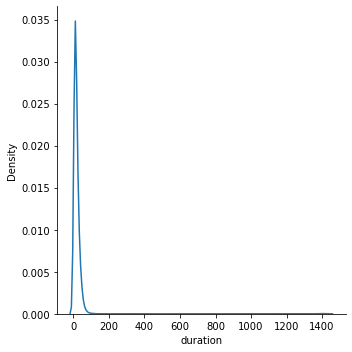

In [65]:
sns.displot(df.duration, kind='kde')

In [66]:
df['duration'].describe(percentiles=[0.1, 0.2, 0.95, 0.98, 0.99])

count    76518.000000
mean        19.927896
std         59.338594
min          0.000000
10%          4.750000
20%          7.000000
50%         13.883333
95%         44.000000
98%         56.000000
99%         67.158167
max       1439.600000
Name: duration, dtype: float64

Most of the data is within one hour (percentile 98% = 59.33 min). Also some very short trips, 20% less than 0.066 min
Check the % of trips that are within the range of 1 mintute to 1 hour.

In [67]:
print(f'% of trips within 1-60 min: {((df.duration >= 1) & (df.duration<=60)).mean()}')

% of trips within 1-60 min: 0.9658903787344154


In [68]:
df = df[(df.duration >= 1) & (df.duration<=60)]

For the first model, just use the following features: PULocationID, DOLocationID and trip_distance. 

Feature engineering: Also, from the date-times we can extract day, month, etc, that gives very valuable information to the model. But not now.

DictVectorizer treates any column not numerical as categorical, so we need to convert PULocationID, DOLocationID to str

In [69]:
categorical_features = ['PULocationID', 'DOLocationID']
numerical_features=  ['trip_distance']
target = 'duration'

In [70]:
df[categorical_features] = df[categorical_features].astype('str')

In [261]:
df.dtypes

VendorID                          int64
lpep_pickup_datetime     datetime64[ns]
lpep_dropoff_datetime    datetime64[ns]
store_and_fwd_flag               object
RatecodeID                      float64
PULocationID                     object
DOLocationID                     object
passenger_count                 float64
trip_distance                   float64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
payment_type                    float64
trip_type                       float64
congestion_surcharge            float64
duration                        float64
dtype: object

# Data Reading and preparation from function

In [126]:
categorical_features = ['PULocationID', 'DOLocationID']
numerical_features=  ['trip_distance']
target = ['duration']

In [127]:
df_train, y_train = read_dataframe(data_sources[0], categorical_features=categorical_features, numerical_features=numerical_features, target=target)
df_val, y_val = read_dataframe(data_sources[1], categorical_features=categorical_features, numerical_features=numerical_features, target=target)

# Encoding

In [131]:
dv = DictVectorizer()

In [132]:
train_dicts = df_train.to_dict(orient='records')
val_dicts = df_val.to_dict(orient='records')

In [133]:
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

In [134]:
X_train.shape

(73908, 507)

In [141]:
y_train = y_train[target].values
y_val = y_val[target].values

# Lineal regression

In [142]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [143]:
y_pred = lr.predict(X_train)

C:\Users\MARCOS\anaconda3\envs\mlops-zoomcamp\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\MARCOS\anaconda3\envs\mlops-zoomcamp\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


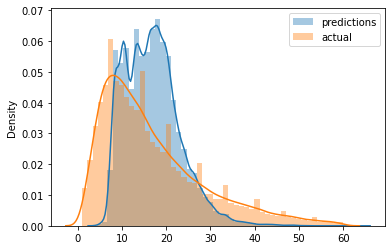

In [144]:
sns.distplot(y_pred, label='predictions')
sns.distplot(y_train, label='actual')
plt.legend()

Check performance in training dataset with rmse (return rmse, so is interpreted as the mean error in minutes)

In [145]:
mean_squared_error(y_train,y_pred, squared=False)

9.775491295103192

The performance of this baseline model is bad. We can use other features, or change the 

# Validation framework
We will use datasets from different months for train and validation

In [146]:
y_pred = lr.predict(X_val)

In [147]:
mean_squared_error(y_val,y_pred, squared=False)

10.47339032019138

# Other models

In [148]:
lr = Lasso(alpha=0.01)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_val)
mean_squared_error(y_val, y_pred, squared=False)

10.812725703916977

In [149]:
lr = Ridge()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_val)
mean_squared_error(y_val, y_pred, squared=False)

10.860753390359754

# Feature engineering
Combine PU and DO (interaction features)

In [151]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [152]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']

In [153]:
dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [154]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

7.479581745570146

Save the best result

In [165]:
import os
if not os.path.exists("./models"):
    os.makedirs("./models")

with open('models/lin_reg_green.bin','bw') as f_out:
    pickle.dump((dv,lr), f_out)

In [164]:
lr = Lasso(0.01)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

11.167275941179728